Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [24]:
import numpy as np
import cv2
import glob
import os

# Define chessboard dimensions
CHESS_WIDTH = 7
CHESS_HEIGHT = 5
VIDEO_NAME = 'out1F'

# prepare object points, like (0,0,0), (1,0,0), (2,0,0), ...(6,5,0)
objp = np.zeros((CHESS_WIDTH * CHESS_HEIGHT, 3), np.float32)
objp[:, :2] = np.mgrid[0:CHESS_WIDTH, 0:CHESS_HEIGHT].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3D points in real-world space
imgpoints = []  # 2D points in image plane.

# Open the video file
video_capture = cv2.VideoCapture('video/' + VIDEO_NAME + '.mp4')

# Set the frame skip interval (1 frame every 30)
frame_skip = 15

frame_count = 0
new_resolution = (1920, 1080)

# Termination criteria for the iterative algorithm
termination_criteria = (cv2.TERM_CRITERIA_EPS +
                        cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Create a directory to save the screen captures named as the video file

output_dir = 'samples/' + VIDEO_NAME
os.makedirs(output_dir, exist_ok=True)
print("Saving frames to ", output_dir)
# Remove all files in the directory
for file in os.listdir(output_dir):
    os.remove(os.path.join(output_dir, file))

# Dictionary to keep track of the number of frames saved for each quadrant
quadrant_frame_count = {0: 0, 1: 0, 2: 0, 3: 0}

while True:
    # Read a frame from the video
    ret, img = video_capture.read()
    if not ret:
        break  # Break the loop if we've reached the end of the video

    # Skip frames based on the frame_skip value
    if frame_count % frame_skip == 0:
        # Resize the frame to the new_resolution
        img = cv2.resize(img, new_resolution)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        found_corners, corners = cv2.findChessboardCorners(gray, (CHESS_WIDTH, CHESS_HEIGHT), None)
        #print("Frame ", frame_count, ":", found_corners)

        # If found, add object points, image points, and save frames for each quadrant
        if found_corners:
            # Determine which quadrant the chessboard is in
            width_half = new_resolution[0] // 2
            height_half = new_resolution[1] // 2
            quadrant = 0  # 0: Top-left, 1: Top-right, 2: Bottom-left, 3: Bottom-right

            if corners[0][0][0] < width_half:
                if corners[0][0][1] < height_half:
                    quadrant = 0
                else:
                    quadrant = 2
            else:
                if corners[0][0][1] < height_half:
                    quadrant = 1
                else:
                    quadrant = 3

            # Check if we've saved 5 frames for this quadrant, if not, save the frame
            if quadrant_frame_count[quadrant] < 4:
                frame_skip = 15
                frame_filename = os.path.join(output_dir, f"quadrant_{quadrant}_frame_{frame_count}.jpg")
                cv2.imwrite(frame_filename, img)
                quadrant_frame_count[quadrant] += 1
                objpoints.append(objp)  # 3D point in real-world space
                imgpoints.append(corners)
                print("Saved frame ", frame_count, " for quadrant ", quadrant)
            else:
                frame_skip = 50
                print("Already saved 5 frames for quadrant ", quadrant)
                print("Skipping frame ", frame_count)
            # Draw and display the corners (optional)
            #cv2.drawChessboardCorners(img, (CHESS_WIDTH, CHESS_HEIGHT), corners, found_corners)
        else:
            frame_skip = 50
            print("No corners found in frame ", frame_count)
            
        

    frame_count += 1

    # Check if we've saved enough frames for all quadrants
    if all(count >= 4 for count in quadrant_frame_count.values()):
        break

video_capture.release()
cv2.destroyAllWindows()


Saving frames to  samples/out1F
No corners found in frame  0
No corners found in frame  50
No corners found in frame  100
No corners found in frame  150
No corners found in frame  200
No corners found in frame  250
No corners found in frame  300
No corners found in frame  350
No corners found in frame  400
No corners found in frame  450
Saved frame  500  for quadrant  0
Saved frame  510  for quadrant  0
Saved frame  525  for quadrant  2
Saved frame  540  for quadrant  2
Saved frame  555  for quadrant  0
Saved frame  570  for quadrant  0
Saved frame  585  for quadrant  2
Saved frame  600  for quadrant  2
Already saved 5 frames for quadrant  2
Skipping frame  615
Already saved 5 frames for quadrant  2
Skipping frame  650
Saved frame  700  for quadrant  3
Saved frame  705  for quadrant  3
Saved frame  720  for quadrant  3
Saved frame  735  for quadrant  3
Already saved 5 frames for quadrant  3
Skipping frame  750
No corners found in frame  800
Already saved 5 frames for quadrant  3
Skippi

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

mtx: [[2.01487372e+03 0.00000000e+00 9.78931593e+02]
 [0.00000000e+00 2.04475211e+03 4.36103117e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

dist: [[-4.97580887e-01  1.27615468e+00  1.14360914e-02  1.29886063e-03
  -2.00422153e+00]]



Text(0.5, 1.0, 'Undistorted Image')

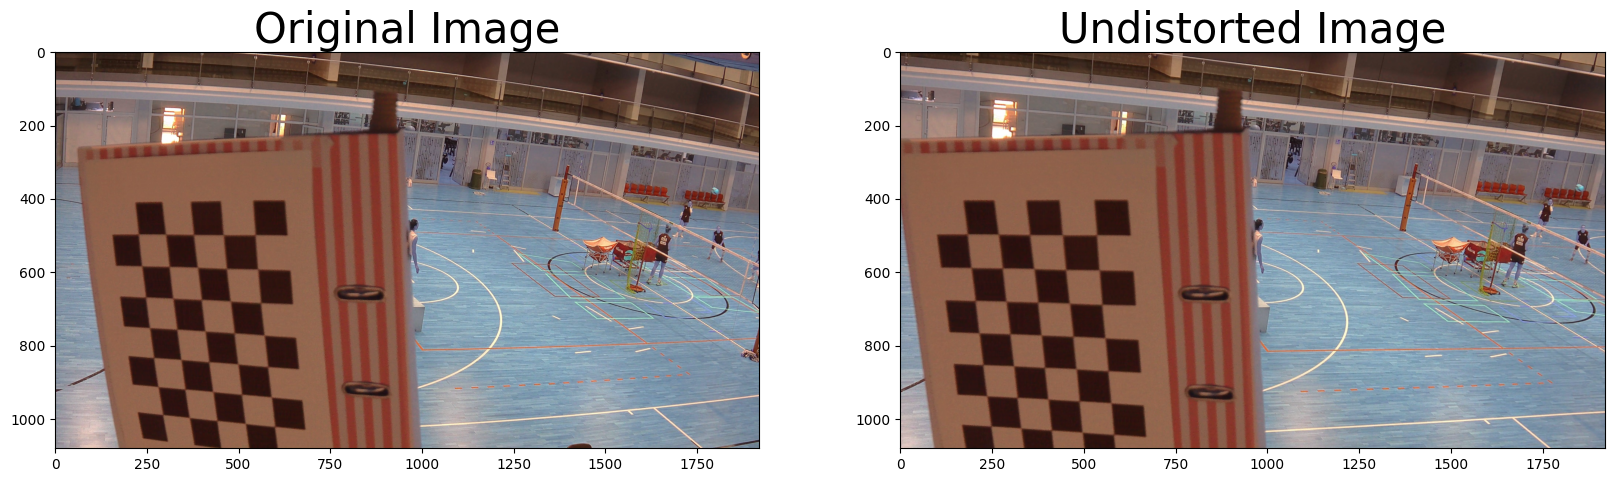

In [33]:
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

# Test undistortion on an image
img = cv2.imread('samples/out1F/quadrant_0_frame_510.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#new camera matrix
#new_mtx = cv2.getOptimalNewCameraMatrix(mtx, dist, img_size, 1, img_size)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output/parameters_' + VIDEO_NAME +'.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output/parameters_" + VIDEO_NAME + ".p", "wb" ) )
# Append to a txt file the parameters
with open('output/parameters.txt', 'a') as f:
    f.write("mtx: " + str(mtx) + "\n")
    f.write("dist: " + str(dist) + "\n")
print("mtx: " + str(mtx) + "\n")
print("dist: " + str(dist) + "\n")

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)